# S-FFSD上的消融实验
### RGTAN以及它的三个变体 RGTAN-A,RGTAN-N,RGTAN-R

##### 模型具体实现请见methods文件夹

In [2]:
import os
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from config import Config
from feature_engineering.data_engineering import data_engineer_benchmark, span_data_2d, span_data_3d
import logging
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import yaml

Python 文件的导入部分，主要用于引入项目中需要的模块和库，为后续的功能实现提供支持。以下是对每个导入的详细解释：

1. **`import os`**:  
   `os` 模块提供了与操作系统交互的功能，例如文件路径操作、环境变量访问等。它通常用于处理文件和目录路径，确保代码能够在不同操作系统上运行。

2. **`from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter`**:  
   `argparse` 是 Python 标准库中的一个模块，用于解析命令行参数。`ArgumentParser` 是核心类，用于定义和解析命令行参数，而 `ArgumentDefaultsHelpFormatter` 可以自动生成帮助信息，并显示参数的默认值。这两个工具通常用于构建灵活的命令行接口。

3. **`from config import Config`**:  
   这行代码从项目中的 [`config`](command:_github.copilot.openRelativePath?%5B%22config%22%5D "config") 模块导入了 [`Config`](command:_github.copilot.openRelativePath?%5B%22Config%22%5D "Config") 类或对象。[`Config`](command:_github.copilot.openRelativePath?%5B%22Config%22%5D "Config") 通常用于管理项目的配置参数，例如路径、超参数或其他全局设置。这种设计可以让代码更易于维护和扩展。

4. **`from feature_engineering.data_engineering import data_engineer_benchmark, span_data_2d, span_data_3d`**:  
   这行代码从项目的 `feature_engineering.data_engineering` 模块中导入了三个函数或类：`data_engineer_benchmark`、`span_data_2d` 和 `span_data_3d`。这些工具可能与特征工程相关，用于处理数据或生成特定的特征，例如二维或三维数据的跨度计算。

5. **`import logging`**:  
   `logging` 模块是 Python 标准库的一部分，用于记录日志信息。它可以帮助开发者跟踪代码的运行状态、调试问题或记录重要事件。通过设置不同的日志级别（如 DEBUG、INFO、WARNING），可以灵活地控制日志输出。

6. **`import numpy as np`**:  
   `numpy` 是一个强大的科学计算库，主要用于处理多维数组和执行数值计算。这里将 `numpy` 重命名为 `np`，这是一个常见的约定，方便代码书写和阅读。

7. **`import pandas as pd`**:  
   `pandas` 是一个流行的数据分析库，提供了强大的数据结构（如 DataFrame）和工具，用于处理和分析结构化数据。这里将 `pandas` 重命名为 `pd`，也是一种常见的约定。

8. **`from sklearn.model_selection import train_test_split`**:  
   这行代码从 `scikit-learn` 库中导入了 `train_test_split` 函数，用于将数据集分割为训练集和测试集。这是机器学习项目中常用的工具，确保模型能够在未见过的数据上进行评估。

9. **`import yaml`**:  
   `yaml` 是一个轻量级的数据序列化格式，常用于配置文件。`yaml` 模块可以解析 YAML 文件，将其转换为 Python 数据结构（如字典），或者将 Python 数据结构写入 YAML 文件。

此处导入了多个标准库和第三方库，以及项目中的自定义模块，涵盖了文件操作、命令行参数解析、特征工程、数据处理、日志记录等功能。这些导入为后续代码的实现提供了必要的工具和支持，体现了模块化和可扩展的设计思想。

In [3]:
logger = logging.getLogger(__name__)

创建了一个与当前模块关联的日志记录器对象，为后续的日志记录提供了基础。这种设计不仅提高了代码的可维护性，还增强了项目的调试能力。

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def parse_args(method):
    yaml_file = {
        'gtan': "config/gtan_cfg.yaml",
        'rgtan': "config/rgtan_cfg.yaml",
        'rgtan-n': "config/rgtan_n_cfg.yaml",
        'rgtan-r': "config/rgtan_r_cfg.yaml",
        'rgtan-a': "config/rgtan_a_cfg.yaml",
        'rgtan-aff': "config/rgtan_aff_cfg.yaml",
    }.get(method, None)

    if not yaml_file:
        raise NotImplementedError(f"Unsupported method: {method}")

    # 读取配置文件
    with open(yaml_file) as file:
        args = yaml.safe_load(file)
    args['method'] = method
    return args

这段代码定义了一个名为 `parse_args` 的函数，用于根据输入的 `method` 参数选择对应的配置文件，并将配置文件中的内容加载为 Python 数据结构。

1. **函数的目的**:
   `parse_args` 函数的主要作用是根据用户提供的 `method` 参数，选择一个预定义的 YAML 配置文件路径，并加载该文件的内容。加载后的配置数据会以字典形式返回，同时添加一个 `method` 键，记录用户选择的 `method`。

2. **配置文件路径的选择**:
   - 函数通过一个字典将不同的 `method` 值映射到对应的配置文件路径。例如：
     - 如果 `method` 是 `'gtan'`，则选择 `"config/gtan_cfg.yaml"`。
     - 如果 `method` 是 `'rgtan'`，则选择 `"config/rgtan_cfg.yaml"`。
   - 使用 `.get(method, None)` 方法从字典中获取对应的路径。如果 `method` 不在字典中，则返回 `None`。

3. **错误处理**:
   - 如果 `method` 不在预定义的字典中（即 `yaml_file` 为 `None`），函数会抛出一个 `NotImplementedError` 异常，并提示用户提供的 `method` 不受支持。这种设计可以防止程序继续运行时出现不可预测的错误。

4. **读取 YAML 配置文件**:
   - 使用 `open(yaml_file)` 打开选定的配置文件，并通过 `yaml.safe_load(file)` 将 YAML 文件的内容加载为 Python 数据结构（通常是字典）。
   - `yaml.safe_load` 是 `PyYAML` 库中的方法，用于安全地加载 YAML 文件，避免潜在的安全问题。

5. **添加 `method` 信息**:
   - 加载的配置数据会被添加一个新的键值对：`args['method'] = method`。这样可以在后续使用配置数据时，明确知道用户选择的 `method`。

6. **返回值**:
   - 函数最终返回加载后的配置数据（字典形式），其中包含 YAML 文件的内容以及用户选择的 `method`。

### 示例用法
假设用户调用函数时传入 `'gtan'`：
```python
args = parse_args('gtan')
```
函数会加载 `"config/gtan_cfg.yaml"` 文件，并返回类似以下的字典：
```python
{
    'method': 'gtan',
    'key1': 'value1',
    'key2': 'value2',
    ...
}
```

### 总结
`parse_args` 函数通过灵活的字典映射和错误处理机制，确保能够根据用户输入加载正确的配置文件，同时提供了清晰的扩展性。如果需要支持新的 `method`，只需在字典中添加新的键值对即可。这种设计简洁且易于维护，非常适合配置管理场景。

In [6]:
def base_load_data(args):
    # 供普通的非图结构的模型使用的S-SSFD
    data_path = "data/S-FFSD.csv"
    feat_df = pd.read_csv(data_path)
    train_size = 1 - args['test_size']

    # 检查是否已有预处理的数据
    if os.path.exists("data/tel_2d.npy"):
        return
    
    # 数据预处理
    features, labels = span_data_2d(feat_df)  # 请确保定义了该函数
    trf, tef, trl, tel = train_test_split(
        features, labels, train_size=train_size, stratify=labels, shuffle=True
    )
    
    # 保存数据
    np.save(args['trainfeature'], trf)
    np.save(args['testfeature'], tef)
    np.save(args['trainlabel'], trl)
    np.save(args['testlabel'], tel)

#### 通过写入method调用相对应的模型

In [7]:
def main(args):
    if args['method'] == 'rgtan':
        from methods.rgtan.rgtan_main import rgtan_main, loda_rgtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features, neigh_features = loda_rgtan_data(args['dataset'], args['test_size'])
        rgtan_main(feat_data, g, train_idx, test_idx, labels, args, cat_features, neigh_features, nei_att_head=args['nei_att_heads'][args['dataset']])

    elif args['method'] == 'gtan':
        from methods.gtan.gtan_main import gtan_main, load_gtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features = load_gtan_data(args['dataset'], args['test_size'])
        gtan_main(feat_data, g, train_idx, test_idx, labels, args, cat_features)

    elif args['method'] == 'rgtan-n':
        from methods.rgtan_n.rgtan_n_main import rgtan_n_main, loda_rgtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features, neigh_features = loda_rgtan_data(args['dataset'], args['test_size'])
        rgtan_n_main(feat_data, g, train_idx, test_idx, labels, args, cat_features, neigh_features, nei_att_head=args['nei_att_heads'][args['dataset']])

    elif args['method'] == 'rgtan-r':
        from methods.rgtan_r.rgtan_r_main import rgtan_r_main, loda_rgtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features, neigh_features = loda_rgtan_data(args['dataset'], args['test_size'])
        rgtan_r_main(feat_data, g, train_idx, test_idx, labels, args, cat_features, neigh_features, nei_att_head=args['nei_att_heads'][args['dataset']])

    elif args['method'] == 'rgtan-a':
        from methods.rgtan_a.rgtan_a_main import rgtan_a_main, loda_rgtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features, neigh_features = loda_rgtan_data(args['dataset'], args['test_size'])
        rgtan_a_main(feat_data, g, train_idx, test_idx, labels, args, cat_features, neigh_features, nei_att_head=args['nei_att_heads'][args['dataset']])
        
    elif args['method'] == 'rgtan-aff':
        from methods.rgtan_aff.rgtan_aff_main import rgtan_aff_main, loda_rgtan_data
        feat_data, labels, train_idx, test_idx, g, cat_features, neigh_features = loda_rgtan_data(
            args['dataset'], args['test_size']) 
        rgtan_aff_main(feat_data, g, train_idx, test_idx, labels, args,
                       cat_features, neigh_features, nei_att_head=args['nei_att_heads'][args['dataset']])
    else:
        raise NotImplementedError("Unsupported method.")

以下是在S-FFSD数据集上进行的原始模型和消融实验训练评估可视化
相关参数配置如下：

batch_size: 64

hid_dim: 256

lr: 0.002

wd: !!float 1e-4

n_layers: 2

dropout: [0.2, 0.1]

device: "cuda:0"

early_stopping: 10

n_fold: 5

seed: 2023

max_epochs: 100

gated: True

dataset: S-FFSD

test_size: 0.4

nei_att_heads:

    yelp: 4

    amazon: 5
    
    S-FFSD: 9

### exp1---rgtan---S-FFSD
原论文模型，融合了时间信息、类别属性信息以及邻居风险结构信息

实现主要由5个模块：
- `PosEncoding`:位置编码模块
- `TransformerConv`：图注意力卷积模块
- `Tabular1DCNN2`：时间卷积模块
- `TransEmbedding`：属性嵌入模块
- `RGTAN`：主模块

In [13]:
method = 'rgtan'
args = parse_args(method)
base_load_data(args)
main(args)

Type: 100%|██████████| 166/166 [00:00<00:00, 486.68it/s]


neighborhood feature loaded for nn input.
Training fold 1
In epoch:000|batch:0000, train_loss:0.649450, train_ap:0.1973, train_acc:0.6739, train_auc:0.4384
In epoch:000|batch:0010, train_loss:0.541616, train_ap:0.1883, train_acc:0.7556, train_auc:0.4899
In epoch:000|batch:0020, train_loss:0.522768, train_ap:0.2463, train_acc:0.8525, train_auc:0.5755
In epoch:000|batch:0030, train_loss:0.515819, train_ap:0.3324, train_acc:0.8000, train_auc:0.5275
In epoch:000|batch:0040, train_loss:0.502669, train_ap:0.7024, train_acc:0.9811, train_auc:0.8333
In epoch:000|batch:0050, train_loss:0.487984, train_ap:0.2660, train_acc:0.7955, train_auc:0.6146
In epoch:000|batch:0060, train_loss:0.479830, train_ap:0.5120, train_acc:0.8302, train_auc:0.6728
In epoch:000|batch:0070, train_loss:0.470580, train_ap:0.3520, train_acc:0.7500, train_auc:0.5325
In epoch:000|batch:0080, train_loss:0.466999, train_ap:0.3175, train_acc:0.7500, train_auc:0.6408
In epoch:000|batch:0090, train_loss:0.467011, train_ap:0.581

### exp2---rgtan-a---S-FFSD
将RGTAN模型中的TransformerConv层（GTGA的实现）替换为DGL库中标准的dgl.nn.pytorch.GraphConv层。GraphConv执行的是简单的、权重相等的邻居信息聚合，不包含复杂的注意力计算和门控机制。

In [14]:
method = 'rgtan-a'  # 可以根据需要更改
args = parse_args(method)
base_load_data(args)
main(args)

Type: 100%|██████████| 166/166 [00:00<00:00, 410.11it/s]


neighborhood feature loaded for nn input.
Training fold 1
In epoch:000|batch:0000, train_loss:0.718776, train_ap:0.3189, train_acc:0.4600, train_auc:0.5438
In epoch:000|batch:0010, train_loss:0.554179, train_ap:0.6087, train_acc:0.8265, train_auc:0.8396
In epoch:000|batch:0020, train_loss:0.483072, train_ap:0.3471, train_acc:0.8713, train_auc:0.6879
In epoch:000|batch:0030, train_loss:0.472626, train_ap:0.5081, train_acc:0.8488, train_auc:0.7277
In epoch:000|batch:0040, train_loss:0.463274, train_ap:0.4991, train_acc:0.8980, train_auc:0.7296
In epoch:000|batch:0050, train_loss:0.456776, train_ap:0.4578, train_acc:0.8333, train_auc:0.6343
In epoch:000|batch:0060, train_loss:0.448709, train_ap:0.5608, train_acc:0.7849, train_auc:0.7321
In epoch:000|batch:0070, train_loss:0.436560, train_ap:0.7447, train_acc:0.8942, train_auc:0.8773
In epoch:000|batch:0080, train_loss:0.429200, train_ap:0.4140, train_acc:0.8133, train_auc:0.6339
In epoch:000|batch:0090, train_loss:0.425852, train_ap:0.446

### exp3---rgtan-n---S-FFSD
禁止模型使用在 data_process.py中预计算并保存在_neigh_feat.csv 文件中的邻居统计特征。具体做法是在 RGTAN模型__init__方法中，当初始化 TransEmbedding模块时不传入neigh_features参数，确保后续所有层不使用由这些特征产生的nei_h。

In [15]:
method = 'rgtan-n'  # 可以根据需要更改
args = parse_args(method)
base_load_data(args)
main(args)

Type: 100%|██████████| 166/166 [00:00<00:00, 435.80it/s]


neighborhood feature loaded for nn input.
Training fold 1
In epoch:000|batch:0000, train_loss:0.663828, train_ap:0.2258, train_acc:0.6040, train_auc:0.4840
In epoch:000|batch:0010, train_loss:0.530851, train_ap:0.1793, train_acc:0.8140, train_auc:0.4704
In epoch:000|batch:0020, train_loss:0.504850, train_ap:0.1544, train_acc:0.8542, train_auc:0.4312
In epoch:000|batch:0030, train_loss:0.491925, train_ap:0.4013, train_acc:0.8155, train_auc:0.6028
In epoch:000|batch:0040, train_loss:0.478889, train_ap:0.5653, train_acc:0.8384, train_auc:0.7261
In epoch:000|batch:0050, train_loss:0.465978, train_ap:0.3964, train_acc:0.8734, train_auc:0.6471
In epoch:000|batch:0060, train_loss:0.459502, train_ap:0.4156, train_acc:0.8105, train_auc:0.6586
In epoch:000|batch:0070, train_loss:0.451621, train_ap:0.5245, train_acc:0.8913, train_auc:0.6904
In epoch:000|batch:0080, train_loss:0.446779, train_ap:0.6268, train_acc:0.8824, train_auc:0.7202
In epoch:000|batch:0090, train_loss:0.447785, train_ap:0.503

### exp4---rgtan-r---S-FFSD
完全移除了与标签嵌入相关的模块，在其forward方法中，也不再将labels作为输入特征进行处理和添加到节点表示h中。模型仅依赖原始的节点属性和邻居结构特征进行学习。

In [8]:
method = 'rgtan-r'  # 可以根据需要更改
args = parse_args(method)
base_load_data(args)
main(args)

Type: 100%|██████████| 166/166 [00:00<00:00, 481.54it/s]


neighborhood feature loaded for nn input.
Training fold 1
In epoch:000|batch:0000, train_loss:0.697929, train_ap:0.3544, train_acc:0.5579, train_auc:0.4886
In epoch:000|batch:0010, train_loss:0.536214, train_ap:0.2742, train_acc:0.8265, train_auc:0.5799
In epoch:000|batch:0020, train_loss:0.514729, train_ap:0.4180, train_acc:0.8571, train_auc:0.6846
In epoch:000|batch:0030, train_loss:0.498650, train_ap:0.6110, train_acc:0.8235, train_auc:0.7034
In epoch:000|batch:0040, train_loss:0.489109, train_ap:0.3571, train_acc:0.8532, train_auc:0.5921
In epoch:000|batch:0050, train_loss:0.483717, train_ap:0.4019, train_acc:0.7917, train_auc:0.7457
In epoch:000|batch:0060, train_loss:0.473196, train_ap:0.4869, train_acc:0.7955, train_auc:0.6781
In epoch:000|batch:0070, train_loss:0.467237, train_ap:0.3756, train_acc:0.9149, train_auc:0.5029
In epoch:000|batch:0080, train_loss:0.463783, train_ap:0.4170, train_acc:0.8667, train_auc:0.5604
In epoch:000|batch:0090, train_loss:0.458335, train_ap:0.223

## 柱形图可视化比较 & 结果分析
S-FFSD 的特定子集为基于图的模型提供了一个稍微“容易”的任务，从而缩小了复杂的注意力 GNN 和更简单的 GCN 之间的性能差距。

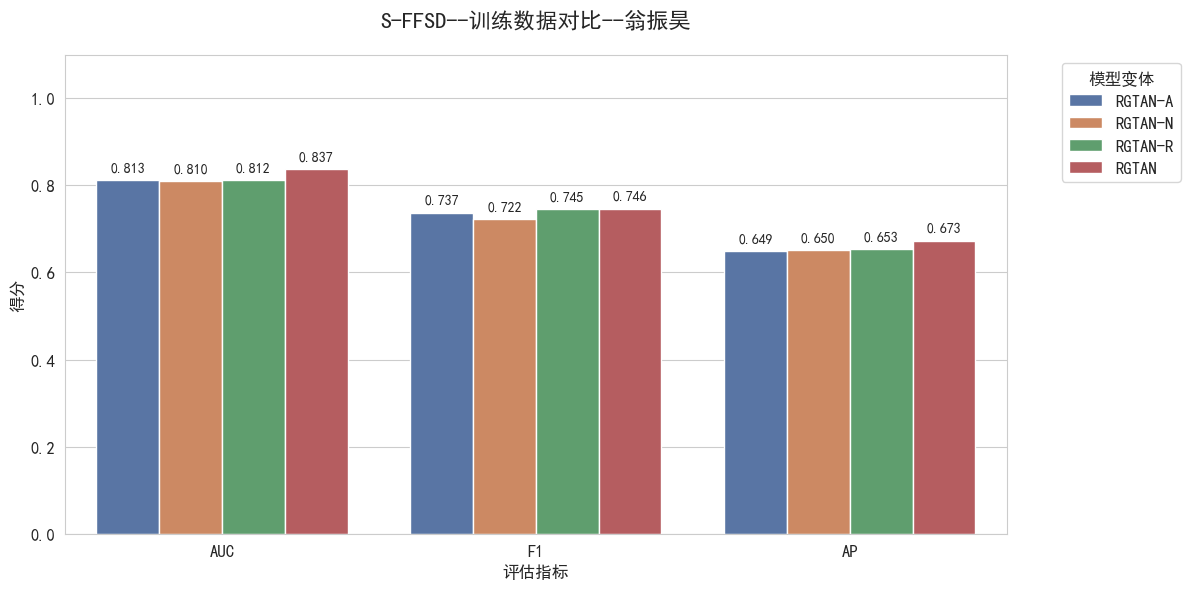

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.font_manager as fm

# 1. 中文字体配置（确保路径正确）
font_path = 'C:/Windows/Fonts/simhei.ttf'  # Windows系统黑体路径
myfont = fm.FontProperties(fname=font_path, size=12)
rcParams['font.sans-serif'] = ['SimHei']  # 全局设置
rcParams['axes.unicode_minus'] = False    # 解决负号显示

# 2. 数据准备（移除无效的0.000数据点）
data = {
    '模型': ['RGTAN-A', 'RGTAN-N', 'RGTAN-R', 'RGTAN'],
    'AUC': [0.8127, 0.8101, 0.8123, 0.8372],
    'F1': [0.7373, 0.7220, 0.7454, 0.7464],
    'AP': [0.6488, 0.6503, 0.6527, 0.6729]
}
df = pd.DataFrame(data)

df_melted = df.melt(id_vars=['模型'],
                    var_name='指标',
                    value_name='得分')

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='指标', y='得分', hue='模型', data=df_melted,
                 palette=['#4C72B0', '#DD8452', '#55A868', '#C44E52'])

plt.title('S-FFSD--训练数据对比--翁振昊', fontproperties=myfont, fontsize=16, pad=20)
plt.xlabel('评估指标', fontproperties=myfont)
plt.ylabel('得分', fontproperties=myfont)
plt.ylim(0, 1.1)

for p in ax.patches:
    height = p.get_height()
    if height > 0.01:  # 忽略接近0的值
        ax.text(p.get_x() + p.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', fontsize=10, fontproperties=myfont)

legend = ax.legend(title='模型变体',
                  bbox_to_anchor=(1.05, 1),
                  loc='upper left',
                  prop=myfont)
legend.get_title().set_fontproperties(myfont)

plt.xticks(fontproperties=myfont)
plt.yticks(fontproperties=myfont)
plt.tight_layout()
plt.savefig('S-FFSD_训练数据对比.png', dpi=300, bbox_inches='tight', facecolor='white')  # 避免背景透明
plt.show()

### RGTAN-R 
去除风险嵌入（标签传播）会导致 AUC 和 AP 明显下降，而 F1 则略有下降。这表明，将已知的标签信息作为一个特征并在整个图表中传播是有益的，并且对模型的性能有积极贡献 ，特别是在它正确对欺诈交易进行排名（AUC 和 AP）的能力方面。F1分数相对稳定可能表明，虽然总体排名和精度-召回率平衡受到影响，但模型仍然可以在所选阈值上实现相似的精度和召回率的调和均值。

### RGTAN-N
删除邻居风险感知嵌入层会导致所有指标的性能明显下降。此组件捕获有关多跳邻居的统计信息（如其程度和风险计数 ），非常重要。 它可能有助于模型识别与欺诈相关的风险邻域或异常结构模式。F1 分数的下降在这里比 RGTAN-R 更明显。

### RGTAN-A
在 S-FFSD 结果中，与 RGTAN 相比，RGTAN-A 的性能下降，但这种下降并不明显大于 RGTAN-R 或 RGTAN-N。事实上，它的 F1 分数比 RGTAN-N 的要好,与论文的结果有一定的出入

## Why?
在 Amazon 数据集上，RGTAN-A结果确实与论文很吻合（下降幅度更大），但是在S-FFSD上却没有如此表现。

（1）我猜测是S-FFSD 是论文中使用的 FFSD 数据集的一个明显更小或结构不同的子集 ，那么注意力机制的作用和影响可能会发生变化在较小或较稀疏的图形中，复杂的注意力机制的好处可能不太明显。简单的图形卷积（RGTAN-A 中的 GraphConv）可能足以捕获必要的邻域信息。
    
（2） RGTAN 的超参数（头部数量、隐藏维度、层数）可能针对论文原始数据集上的完整模型进行了调整。这些相同的超参数可能不是消融 RGTAN-A 模型的最佳选择，尤其是在可能不同的 S-FFSD 子集上。

In [1]:
from nbconvert import HTMLExporter
import nbformat

# 加载notebook文件
with open('S-FFSD_exp_wengzhenhao.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

html_exporter = HTMLExporter()
html, resources = html_exporter.from_notebook_node(nb)

# 写入HTML文件
with open('S-FFSD_exp_wengzhenhao.html', 'w') as f:
    f.write(html)